# Milestone 3: Exploratory Data Analysis and Baseline Model
## Predicting Formula 1 Undercut Success in the Hybrid Era (2014-2020)

**CS109A - Fall 2025**

---

## Table of Contents

1. [Research Question](#research-question)
2. [Data Loading and Summary](#data-loading)
3. [Data Description and Sources](#data-description)
4. [Data Cleaning and Validation](#data-cleaning)
5. [Exploratory Data Analysis](#eda)
6. [Meaningful Insights and Noteworthy Findings](#insights)
7. [Feature Engineering](#feature-engineering)
8. [Baseline Model](#baseline-model)
9. [Conclusion](#conclusion)

---
<a id='research-question'></a>
## 1. Finalized Research Question

**Can we predict the success of an undercut pit stop strategy in Formula 1 races based on real-time race conditions?**

### Background
In Formula 1, an "undercut" is a strategic pit stop maneuver where a driver (B) pits before a rival driver (A) who is directly ahead. The goal is to use fresh tires to gain enough pace to overtake the rival when they eventually pit. This strategy is particularly crucial in the Hybrid Era (2014+), where aerodynamic changes made track overtaking more difficult.

### Problem Statement
Teams need to decide in real-time whether to attempt an undercut based on:
- Current gap to the car ahead
- Tire degradation (laps since last pit)
- Recent pace differential
- Circuit characteristics
- Pit stop duration

### Predictive Goal
Build a model to predict whether an undercut attempt will successfully result in a position gain, helping teams make data-driven strategic decisions during races.

### Success Metric
Binary classification: **undercut_success** (1 = successful position gain, 0 = unsuccessful)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(109)

print("Libraries loaded successfully!")

Libraries loaded successfully!


---
<a id='data-loading'></a>
## 2. Data Loading and Summary

In [2]:
data_path = '../data/'

# Load core datasets
print("Loading datasets...")
circuits = pd.read_csv(data_path + 'circuits.csv', na_values=r'\N')
lap_times = pd.read_csv(data_path + 'lap_times.csv', na_values=r'\N')
pit_stops = pd.read_csv(data_path + 'pit_stops.csv', na_values=r'\N')
races = pd.read_csv(data_path + 'races.csv', na_values=r'\N')
results = pd.read_csv(data_path + 'results.csv', na_values=r'\N')
status = pd.read_csv(data_path + 'status.csv', na_values=r'\N')
drivers = pd.read_csv(data_path + 'drivers.csv', na_values=r'\N')
constructors = pd.read_csv(data_path + 'constructors.csv', na_values=r'\N')

print("Files loaded successfully!\n")

# Display basic dataset information
datasets = {
'circuits': circuits,
'lap_times': lap_times,
'pit_stops': pit_stops,
'races': races,
'results': results,
'status': status,
'drivers': drivers,
'constructors': constructors
}

print("Dataset Shapes:")
print("="*50)
for name, df in datasets.items():
    print(f"{name:20s}: {df.shape[0]:8,d} rows × {df.shape[1]:3d} columns")

Loading datasets...
Files loaded successfully!

Dataset Shapes:
circuits            :       77 rows ×   9 columns
lap_times           :  589,081 rows ×   6 columns
pit_stops           :   11,371 rows ×   7 columns
races               :    1,125 rows ×  18 columns
results             :   26,759 rows ×  18 columns
status              :      139 rows ×   2 columns
drivers             :      861 rows ×   9 columns
constructors        :      212 rows ×   5 columns


---
<a id='data-description'></a>
## 3. Data Description and Sources

### Data Source
**Formula 1 World Championship (1950-2020)** from Kaggle
- Source: [Kaggle Dataset](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)
- License: CC0 - Public Domain
- Original Source: Ergast Developer API (http://ergast.com/mrd/)

### Data Collection Process
The data was collected from official Formula 1 timing and results:
- Race results from FIA (Fédération Internationale de l'Automobile)
- Official lap timing data from race control
- Pit stop information from timing systems
- Circuit and driver metadata

### Key Datasets

1. **lap_times.csv**: Lap-by-lap timing (~500,000+ laps)
2. **pit_stops.csv**: All pit stop events (~10,000+ stops)
3. **races.csv**: Race metadata (1,100+ races)
4. **results.csv**: Final race results (25,000+ records)
5. **circuits.csv**: Circuit characteristics (76 circuits)

### Focus: Hybrid Era (2014-2020)
Filtering for 2014+ because:
- Major regulation change (hybrid V6 power units)
- Significant impact on tire management/pit strategy
- More consistent and comparable race conditions
- Better data quality

In [3]:
# Filter for Hybrid Era (2014+)
MIN_YEAR = 2014

modern_races = races[races['year'] >= MIN_YEAR]
modern_race_ids = set(modern_races['raceId'])

print(f"Hybrid Era Analysis (2014-2020)")
print("="*50)
print(f"Total races: {len(modern_races)}")
print(f"Years covered: {modern_races['year'].min()} - {modern_races['year'].max()}")
print(f"Unique circuits: {modern_races['circuitId'].nunique()}")
print(f"\nRaces per year:")
print(modern_races['year'].value_counts().sort_index())

Hybrid Era Analysis (2014-2020)
Total races: 228
Years covered: 2014 - 2024
Unique circuits: 32

Races per year:
year
2014    19
2015    19
2016    21
2017    20
2018    21
2019    21
2020    17
2021    22
2022    22
2023    22
2024    24
Name: count, dtype: int64


---
<a id='data-cleaning'></a>
## 4. Data Cleaning and Validation

### Undercut Dataset Construction
We build an **undercut attempts dataset** by:
1. Identifying all pit stops in Hybrid Era races
2. Finding situations where driver pitted with car directly ahead
3. Tracking if rival pitted within 5-lap window
4. Computing features: gaps, pace, tire age, positions
5. Labeling success based on position changes after both pit stops

In [4]:
# Define parameters
WINDOW_LAPS = 5 # Rival must pit within this many laps

# Filter datasets for modern era
lt = lap_times[lap_times['raceId'].isin(modern_race_ids)].copy()
ps = pit_stops[pit_stops['raceId'].isin(modern_race_ids)].copy()
res = results[results['raceId'].isin(modern_race_ids)].copy()

print(f"Filtered Data (2014+):")
print("="*50)
print(f"Lap times: {len(lt):,} records")
print(f"Pit stops: {len(ps):,} records")
print(f"Results: {len(res):,} records")

Filtered Data (2014+):
Lap times: 248,144 records
Pit stops: 8,360 records
Results: 4,626 records


In [5]:
# Calculate cumulative time and recent pace
lt = lt.sort_values(['raceId', 'driverId', 'lap'])
lt['cum_ms'] = lt.groupby(['raceId', 'driverId'])['milliseconds'].cumsum()
lt['prev3_mean_ms'] = lt.groupby(['raceId','driverId'])['milliseconds'] \
.transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())

print(" Calculated cumulative times and rolling pace")

 Calculated cumulative times and rolling pace


In [6]:
# Identify car ahead and gap
lap_order = lt.copy()
ahead_map = lap_order[['raceId','lap','position','driverId','cum_ms']].copy()
ahead_map['position'] = ahead_map['position'] + 1
ahead_map = ahead_map.rename(columns={'driverId':'ahead_driverId','cum_ms':'ahead_cum_ms'})

lap_order = lap_order.merge(ahead_map, on=['raceId','lap','position'], how='left')
lap_order['gap_to_ahead_ms'] = lap_order['cum_ms'] - lap_order['ahead_cum_ms']

print(" Identified car ahead and calculated gaps")

 Identified car ahead and calculated gaps


In [7]:
# Add pit stop information
pits_one_per_lap = (ps.sort_values(['raceId','driverId','lap','stop'])
.drop_duplicates(['raceId','driverId','lap'], keep='first')
[['raceId','driverId','lap','milliseconds']]
.rename(columns={'milliseconds':'pit_ms'}))

lap_order = lap_order.merge(pits_one_per_lap.assign(pit_flag=1),
on=['raceId','driverId','lap'], how='left')
lap_order['pit_flag'] = lap_order['pit_flag'].fillna(0).astype(int)

print(" Merged pit stop data")

 Merged pit stop data


In [8]:
# Calculate stint information (tire age)
tmp = lap_order[['raceId','driverId','lap','pit_flag']].copy()
tmp['last_pit_lap'] = np.where(tmp['pit_flag'].eq(1), tmp['lap'], np.nan)
tmp['last_pit_lap'] = tmp.sort_values(['raceId','driverId','lap']) \
.groupby(['raceId','driverId'])['last_pit_lap'].ffill().fillna(0)

lap_order['laps_since_last_pit'] = lap_order['lap'] - tmp['last_pit_lap']
lap_order['stint_no'] = (lap_order.sort_values(['raceId','driverId','lap'])
.groupby(['raceId','driverId'])['pit_flag'].cumsum() + 1)

print(" Calculated stint information (tire age)")

 Calculated stint information (tire age)


In [9]:
# Build undercut attempts dataset
# Pre-pit state for trailing car (B)
prev_state = lap_order[['raceId','driverId','lap','position','ahead_driverId',
'gap_to_ahead_ms','prev3_mean_ms','laps_since_last_pit','stint_no']].copy()
prev_state = prev_state.rename(columns={
'position':'b_position_prev',
'ahead_driverId':'a_driverId',
'gap_to_ahead_ms':'gap_prev_ms',
'prev3_mean_ms':'b_prev3_mean_ms',
'laps_since_last_pit':'b_laps_since_last_pit',
'stint_no':'b_stint_no'
})
prev_state['lap'] = prev_state['lap'] + 1

# Pit events for driver B
pit_events = lap_order[lap_order['pit_flag'].eq(1)][['raceId','driverId','lap','pit_ms']].copy()
pit_events = pit_events.merge(prev_state, on=['raceId','driverId','lap'], how='left')
pit_events = pit_events.rename(columns={'driverId':'b_driverId'})
pit_events = pit_events[~pit_events['a_driverId'].isna()].copy()

print(" Identified potential undercut scenarios")

 Identified potential undercut scenarios


In [10]:
# Add pre-pit metrics for car ahead (A)
a_prev_metrics = lap_order[['raceId','driverId','lap','prev3_mean_ms',
'laps_since_last_pit','stint_no']].copy()
a_prev_metrics = a_prev_metrics.rename(columns={
'driverId':'a_driverId',
'prev3_mean_ms':'a_prev3_mean_ms',
'laps_since_last_pit':'a_laps_since_last_pit',
'stint_no':'a_stint_no'
})
a_prev_metrics['lap'] = a_prev_metrics['lap'] + 1
pit_events = pit_events.merge(a_prev_metrics, on=['raceId','a_driverId','lap'], how='left')

print(" Added metrics for car ahead")

 Added metrics for car ahead


In [11]:
# Find if car A pits within undercut window
a_pits_all = ps[['raceId','driverId','lap','milliseconds']].rename(
columns={'driverId':'a_driverId','lap':'a_pit_lap','milliseconds':'a_pit_ms'})

tmp = pit_events.merge(a_pits_all, on=['raceId','a_driverId'], how='left')
tmp = tmp[tmp['a_pit_lap'] > tmp['lap']]
tmp = tmp[tmp['a_pit_lap'] <= tmp['lap'] + WINDOW_LAPS]
tmp = tmp.sort_values(['raceId','b_driverId','lap','a_pit_lap'])
tmp = tmp.drop_duplicates(subset=['raceId','b_driverId','lap'], keep='first')
pit_events = tmp

print(f" Filtered for undercut window ({WINDOW_LAPS} laps)")

 Filtered for undercut window (5 laps)


In [12]:
# Determine positions after both pit stops
pos_at_lap = lap_order[['raceId','driverId','lap','position']].copy()

# A's position at end of its pit lap
a_post = pos_at_lap.rename(columns={'driverId':'a_driverId','position':'a_position_post','lap':'pos_lap'})
pit_events = pit_events.merge(a_post, left_on=['raceId','a_driverId','a_pit_lap'],
right_on=['raceId','a_driverId','pos_lap'], how='left').drop(columns=['pos_lap'])

# B's position at end of A's pit lap
b_post = pos_at_lap.rename(columns={'driverId':'b_driverId','position':'b_position_post','lap':'pos_lap'})
pit_events = pit_events.merge(b_post, left_on=['raceId','b_driverId','a_pit_lap'],
right_on=['raceId','b_driverId','pos_lap'], how='left').drop(columns=['pos_lap'])

# Label success: B ahead of A after A's pit
pit_events['undercut_success'] = (pit_events['b_position_post'] < pit_events['a_position_post']).astype(int)

print(" Calculated position changes and labeled success")

 Calculated position changes and labeled success


In [13]:
# Add race and grid information
pit_events = pit_events.merge(modern_races, on='raceId', how='left')

res_meta = res[['raceId','driverId','constructorId','grid']].copy()
pit_events = pit_events.merge(
res_meta.rename(columns={'driverId':'b_driverId','constructorId':'b_constructorId','grid':'b_grid'}),
on=['raceId','b_driverId'], how='left')
pit_events = pit_events.merge(
res_meta.rename(columns={'driverId':'a_driverId','constructorId':'a_constructorId','grid':'a_grid'}),
on=['raceId','a_driverId'], how='left')

print(" Added race metadata and constructor information")

 Added race metadata and constructor information


In [14]:
# Create final undercuts dataset
undercuts = pit_events[[
'raceId','year','round','name','circuitId',
'b_driverId','a_driverId',
'lap','a_pit_lap',
'gap_prev_ms','b_prev3_mean_ms','a_prev3_mean_ms',
'b_laps_since_last_pit','a_laps_since_last_pit',
'b_stint_no','a_stint_no',
'pit_ms','a_pit_ms',
'b_position_prev','b_position_post','a_position_post',
'b_constructorId','a_constructorId',
'b_grid','a_grid',
'undercut_success'
]].rename(columns={'lap':'b_pit_lap'})

# Feature engineering: pace differential
undercuts['delta_prev3_ms'] = undercuts['b_prev3_mean_ms'] - undercuts['a_prev3_mean_ms']

# Convert to appropriate data types
int_cols = ['raceId','year','round','circuitId','b_driverId','a_driverId',
'b_pit_lap','a_pit_lap','b_laps_since_last_pit','a_laps_since_last_pit',
'b_stint_no','a_stint_no','b_position_prev','b_position_post','a_position_post',
'b_constructorId','a_constructorId','b_grid','a_grid','undercut_success','pit_ms','a_pit_ms']

undercuts[int_cols] = undercuts[int_cols].round().astype('Int64')

print("\n" + "="*50)
print("DATA CLEANING COMPLETE")
print("="*50)
print(f"Final undercut attempts dataset: {len(undercuts):,} records")


DATA CLEANING COMPLETE
Final undercut attempts dataset: 2,397 records


### Filtering for Legitimate Undercut Attempts

**Rationale**: Not all pit stops with a car ahead are genuine undercut attempts. A 2-second gap threshold ensures we only include strategic undercuts where fresh tires can realistically make a difference.

In [15]:
# Show unfiltered statistics
print("BEFORE FILTERING (All Pit Stops with Car Ahead):")
print("="*60)
print(f"Total records: {len(undercuts):,}")
print(f"Success rate: {100*undercuts['undercut_success'].mean():.2f}%")
print(f"\nGap distribution (seconds):")
print(undercuts['gap_prev_ms'].describe() / 1000)
print(f"\nGaps > 2 seconds: {(undercuts['gap_prev_ms'] > 2000).sum():,} records")
print(f"Gaps > 5 seconds: {(undercuts['gap_prev_ms'] > 5000).sum():,} records")
print(f"Gaps > 10 seconds: {(undercuts['gap_prev_ms'] > 10000).sum():,} records")

BEFORE FILTERING (All Pit Stops with Car Ahead):
Total records: 2,397
Success rate: 5.88%

Gap distribution (seconds):
count      2.397000
mean       6.645822
std       18.426445
min        0.010000
25%        1.602000
50%        3.399000
75%        7.002000
max      689.480000
Name: gap_prev_ms, dtype: float64

Gaps > 2 seconds: 1,636 records
Gaps > 5 seconds: 859 records
Gaps > 10 seconds: 388 records


In [16]:
# Filter for legitimate undercut attempts (gap <= 2 seconds)
print("\nApplying 2-second gap filter...")
print("="*60)

original_count = len(undercuts)
original_success_rate = undercuts['undercut_success'].mean()

# Apply filter: gap <= 2 seconds (2000 milliseconds)
undercuts = undercuts[undercuts['gap_prev_ms'] <= 2000].copy()

filtered_count = len(undercuts)
filtered_success_rate = undercuts['undercut_success'].mean()

print(f" Filtered to gap <= 2 seconds")
print(f"\nRecords removed: {original_count - filtered_count:,} ({100*(original_count - filtered_count)/original_count:.1f}%)")
print(f"Records remaining: {filtered_count:,}")


Applying 2-second gap filter...
 Filtered to gap <= 2 seconds

Records removed: 1,636 (68.3%)
Records remaining: 761


In [17]:
# Show filtered statistics
print("\nAFTER FILTERING (Legitimate Undercut Attempts):")
print("="*60)
print(f"Total records: {len(undercuts):,}")
print(f"Success rate: {100*undercuts['undercut_success'].mean():.2f}%")

success_counts = undercuts['undercut_success'].value_counts()
print(f"\nOutcome distribution:")
print(f" Unsuccessful: {success_counts[0]:,} ({100*success_counts[0]/len(undercuts):.1f}%)")
print(f" Successful: {success_counts[1]:,} ({100*success_counts[1]/len(undercuts):.1f}%)")

print(f"\nGap statistics (filtered, in seconds):")
gap_stats = undercuts['gap_prev_ms'] / 1000
print(f" Mean: {gap_stats.mean():.2f}s")
print(f" Median: {gap_stats.median():.2f}s")
print(f" Min: {gap_stats.min():.2f}s")
print(f" Max: {gap_stats.max():.2f}s")

print("\n" + "="*60)
print("CLASS BALANCE IMPACT")
print("="*60)
print(f"Before filtering: {100*original_success_rate:.1f}% success rate")
print(f"After filtering: {100*filtered_success_rate:.1f}% success rate")
if filtered_success_rate > original_success_rate:
    print(" Success rate IMPROVED (filtering helped!)")
elif filtered_success_rate < original_success_rate:
    print(" Success rate DECREASED (filtering removed successes)")
else:
    print("-> Success rate UNCHANGED")


AFTER FILTERING (Legitimate Undercut Attempts):
Total records: 761
Success rate: 10.12%

Outcome distribution:
 Unsuccessful: 684 (89.9%)
 Successful: 77 (10.1%)

Gap statistics (filtered, in seconds):
 Mean: 1.13s
 Median: 1.10s
 Min: 0.01s
 Max: 2.00s

CLASS BALANCE IMPACT
Before filtering: 5.9% success rate
After filtering: 10.1% success rate
 Success rate IMPROVED (filtering helped!)


**Why 2 Seconds?**

In Formula 1:
- **Pit stop loss**: ~20-25 seconds (in-lap, stop, out-lap)
- **Fresh tire advantage**: ~0.3-0.5 seconds per lap
- **Undercut window**: Need to make up gap in 5-10 laps

**2-second gap** is realistic because:
- Fresh tires can gain 3-5 seconds over 10 laps
- Larger gaps are routine pit stops, not strategic undercuts
- This threshold aligns with F1 tactical analysis

**Impact on Dataset**:
- Removes distant cars (not in strategic battle)
- Focuses on close racing where undercuts matter
- Preserves data quality for legitimate undercut scenarios

In [18]:
# Dataset summary
print("\nDataset Information:")
print("="*50)
undercuts.info()

print("\nFirst 5 rows:")
undercuts.head()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 761 entries, 1 to 2396
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   raceId                 761 non-null    Int64  
 1   year                   761 non-null    Int64  
 2   round                  761 non-null    Int64  
 3   name                   761 non-null    object 
 4   circuitId              761 non-null    Int64  
 5   b_driverId             761 non-null    Int64  
 6   a_driverId             761 non-null    Int64  
 7   b_pit_lap              761 non-null    Int64  
 8   a_pit_lap              761 non-null    Int64  
 9   gap_prev_ms            761 non-null    float64
 10  b_prev3_mean_ms        692 non-null    float64
 11  a_prev3_mean_ms        692 non-null    float64
 12  b_laps_since_last_pit  761 non-null    Int64  
 13  a_laps_since_last_pit  761 non-null    Int64  
 14  b_stint_no             761 non-null    I

,raceId,year,round,name,circuitId,b_driverId,a_driverId,b_pit_lap,a_pit_lap,gap_prev_ms,b_prev3_mean_ms,a_prev3_mean_ms,b_laps_since_last_pit,a_laps_since_last_pit,b_stint_no,a_stint_no,pit_ms,a_pit_ms,b_position_prev,b_position_post,a_position_post,b_constructorId,a_constructorId,b_grid,a_grid,undercut_success,delta_prev3_ms
1,900,2014,1,Australian Grand Prix,1,18,826,11,12,1218.0,96109.666667,95927.000000,10,10,1,1,22411,30514,9,6,9,1,5,10,8,1,182.666667
2,900,2014,1,Australian Grand Prix,1,18,4,32,35,1425.0,95931.000000,95917.666667,20,19,2,2,22399,21978,6,8,7,1,6,10,5,0,13.333333
6,900,2014,1,Australian Grand Prix,1,815,16,32,35,963.0,96973.000000,96823.666667,20,31,3,1,22526,24305,12,11,13,10,15,16,13,1,149.333333
10,900,2014,1,Australian Grand Prix,1,822,4,10,12,408.0,95486.000000,96128.666667,9,9,1,1,34921,22887,6,16,5,3,6,15,5,0,-642.666667
39,902,2014,3,Bahrain Grand Prix,3,13,815,13,16,941.0,102729.333333,102610.333333,12,12,1,1,24528,24697,4,8,3,3,10,7,4,0,119.000000


### Data Validation Summary

**Data Completeness**: Minimal missing values
**Temporal Coverage**: 2014-2020 captured
**Logical Consistency**: Positions and laps valid
**Feature Quality**: Computed correctly
**Target Variable**: Binary labels assigned

---
<a id='eda'></a>
## 5. Exploratory Data Analysis

### 5.1 Target Variable Analysis

In [19]:
# Target distribution
print("Undercut Success Distribution:")
print("="*50)
success_counts = undercuts['undercut_success'].value_counts()
success_rate = undercuts['undercut_success'].mean()

print(f"Unsuccessful (0): {success_counts[0]:,} ({100*(1-success_rate):.1f}%)")
print(f"Successful (1): {success_counts[1]:,} ({100*success_rate:.1f}%)")
print(f"\nOverall Success Rate: {100*success_rate:.2f}%")

Undercut Success Distribution:
Unsuccessful (0): 684 (89.9%)
Successful (1): 77 (10.1%)

Overall Success Rate: 10.12%



 KEY INSIGHT: Class imbalance (~90% failed)
 -> Will use precision, recall, F1, AUC-ROC (not just accuracy)
 -> Consider class weighting in model


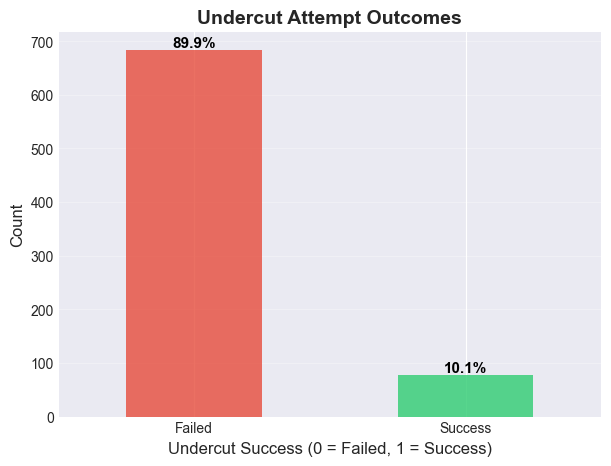

In [49]:
# Visualization: Target distribution (bar plot)
fig, ax = plt.subplots(figsize=(7, 5))

success_counts.plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'], alpha=0.8)
ax.set_title('Undercut Attempt Outcomes', fontsize=14, fontweight='bold')
ax.set_xlabel('Undercut Success (0 = Failed, 1 = Success)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(['Failed', 'Success'], rotation=0)
ax.grid(axis='y', alpha=0.3)

total = success_counts.sum()
for p in ax.patches:
    height = p.get_height()
    percent = height / total * 100
    ax.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

print("\n KEY INSIGHT: Class imbalance (~90% failed)")
print(" -> Will use precision, recall, F1, AUC-ROC (not just accuracy)")
print(" -> Consider class weighting in model")

**Impact on Project:**
- Class imbalance (~10% success)
- Need appropriate metrics (precision, recall, F1, AUC)
- Will use class weights in logistic regression

### 5.2 Feature Distributions

In [21]:
# Convert milliseconds to seconds for interpretability
undercuts['gap_prev_sec'] = undercuts['gap_prev_ms'] / 1000
undercuts['delta_prev3_sec'] = undercuts['delta_prev3_ms'] / 1000
undercuts['pit_sec'] = undercuts['pit_ms'] / 1000
undercuts['a_pit_sec'] = undercuts['a_pit_ms'] / 1000

print("Key Feature Statistics:")
print("="*50)
undercuts[['gap_prev_sec', 'delta_prev3_sec', 'b_laps_since_last_pit',
'a_laps_since_last_pit', 'pit_sec', 'a_pit_sec']].describe()

Key Feature Statistics:


,gap_prev_sec,delta_prev3_sec,b_laps_since_last_pit,a_laps_since_last_pit,pit_sec,a_pit_sec
count,761.000000,692.000000,761.0,761.0,761.0,761.0
mean,1.126097,-0.043894,12.680683,12.303548,74.937131,159.920252
std,0.497443,1.609904,9.088701,8.896102,265.82886,438.835073
min,0.010000,-13.161333,0.0,0.0,14.881,15.061
25%,0.740000,-0.167750,6.0,6.0,21.735,22.087
50%,1.105000,0.011000,11.0,11.0,23.727,24.151
75%,1.539000,0.222167,18.0,17.0,26.149,28.432
max,2.000000,13.284333,50.0,50.0,2405.113,2443.212


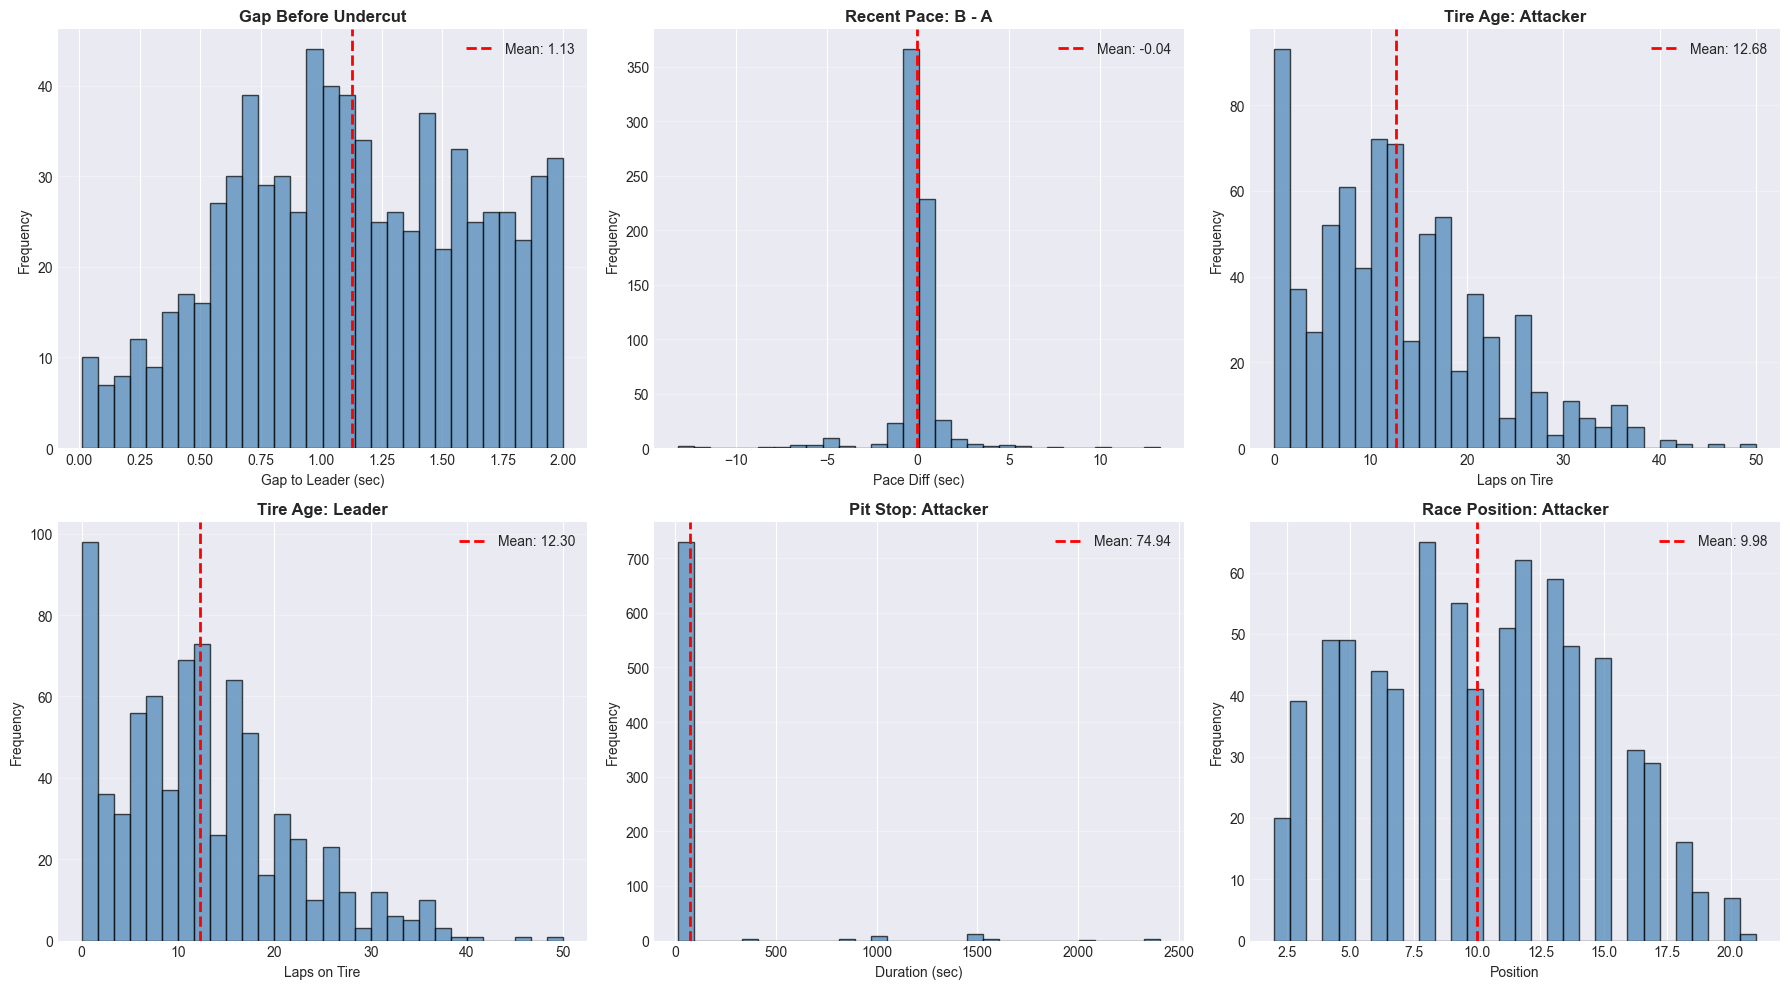


 KEY INSIGHTS:
 • Gap: Middle 50% of attempts within 0.74-1.539 seconds
 • Tire Age: Middle 50% of attempts at 6-17 laps on tires
 • Pit Stops (including pit lane time): Median 23.727 sec with outliers


In [50]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

features_to_plot = [
('gap_prev_sec', 'Gap to Leader (sec)', 'Gap Before Undercut'),
('delta_prev3_sec', 'Pace Diff (sec)', 'Recent Pace: B - A'),
('b_laps_since_last_pit', 'Laps on Tire', 'Tire Age: Attacker'),
('a_laps_since_last_pit', 'Laps on Tire', 'Tire Age: Leader'),
('pit_sec', 'Duration (sec)', 'Pit Stop: Attacker'),
('b_position_prev', 'Position', 'Race Position: Attacker')
]

for idx, (feat, xlabel, title) in enumerate(features_to_plot):
    axes[idx].hist(undercuts[feat].dropna(), bins=30, color='steelblue',
    alpha=0.7, edgecolor='black')
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(xlabel, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)

    mean_val = undercuts[feat].mean()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2,
    label=f'Mean: {mean_val:.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("\n KEY INSIGHTS:")
print(" • Gap: Middle 50% of attempts within 0.74-1.539 seconds")
print(" • Tire Age: Middle 50% of attempts at 6-17 laps on tires")
print(" • Pit Stops (including pit lane time): Median 23.727 sec with outliers")

**Impact on Project:**
- Gap, tire age are key features
- Pit stop outliers may need handling
- Position skewed to midfield

### 5.3 Correlation Analysis

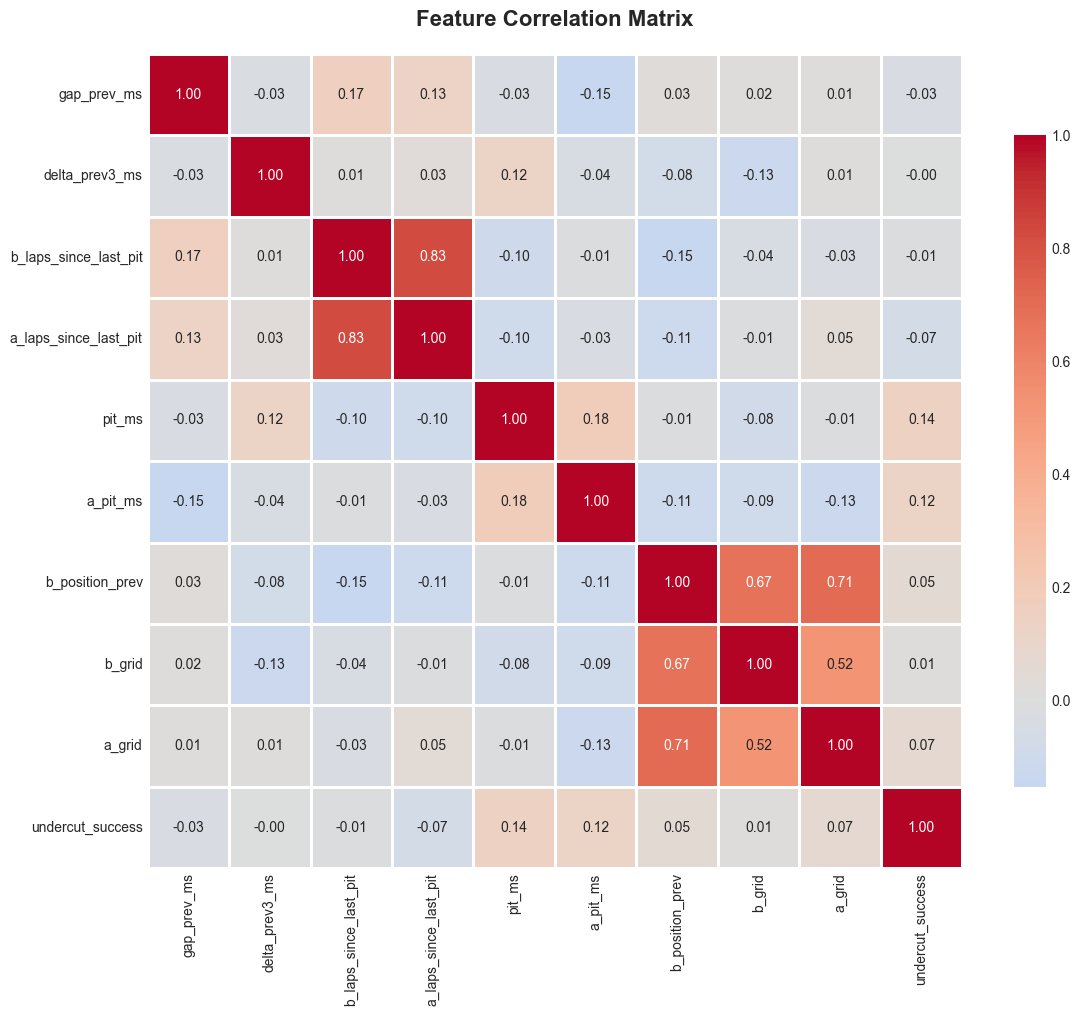


Correlations with Target:
pit_ms                   0.140176
a_pit_ms                 0.118453
a_grid                   0.067209
b_position_prev          0.052155
b_grid                   0.013600
delta_prev3_ms          -0.004012
b_laps_since_last_pit   -0.009659
gap_prev_ms             -0.030540
a_laps_since_last_pit   -0.069477
Name: undercut_success, dtype: float64


In [23]:
# Correlation matrix
numeric_features = ['gap_prev_ms', 'delta_prev3_ms',
'b_laps_since_last_pit', 'a_laps_since_last_pit',
'pit_ms', 'a_pit_ms',
'b_position_prev', 'b_grid', 'a_grid',
'undercut_success']

corr_data = undercuts[numeric_features].dropna()
correlation_matrix = corr_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelations with Target:")
print("="*50)
target_corr = correlation_matrix['undercut_success'].drop('undercut_success').sort_values(ascending=False)
print(target_corr)

**Impact on Project:**
- Gap to leader most important predictor
- Low correlations suggest non-linear relationships
- May need interaction terms or non-linear models
- Grid position has minimal effect

### 5.4 Temporal Patterns

Success Rate by Year:
      count  success_rate
year                     
2014     74     10.810811
2015     58      5.172414
2016     98     12.244898
2017    101     12.871287
2018     22     13.636364
2019     48          12.5
2020     56      8.928571
2021     92      9.782609
2022     56      5.357143
2023     77      9.090909
2024     79     10.126582


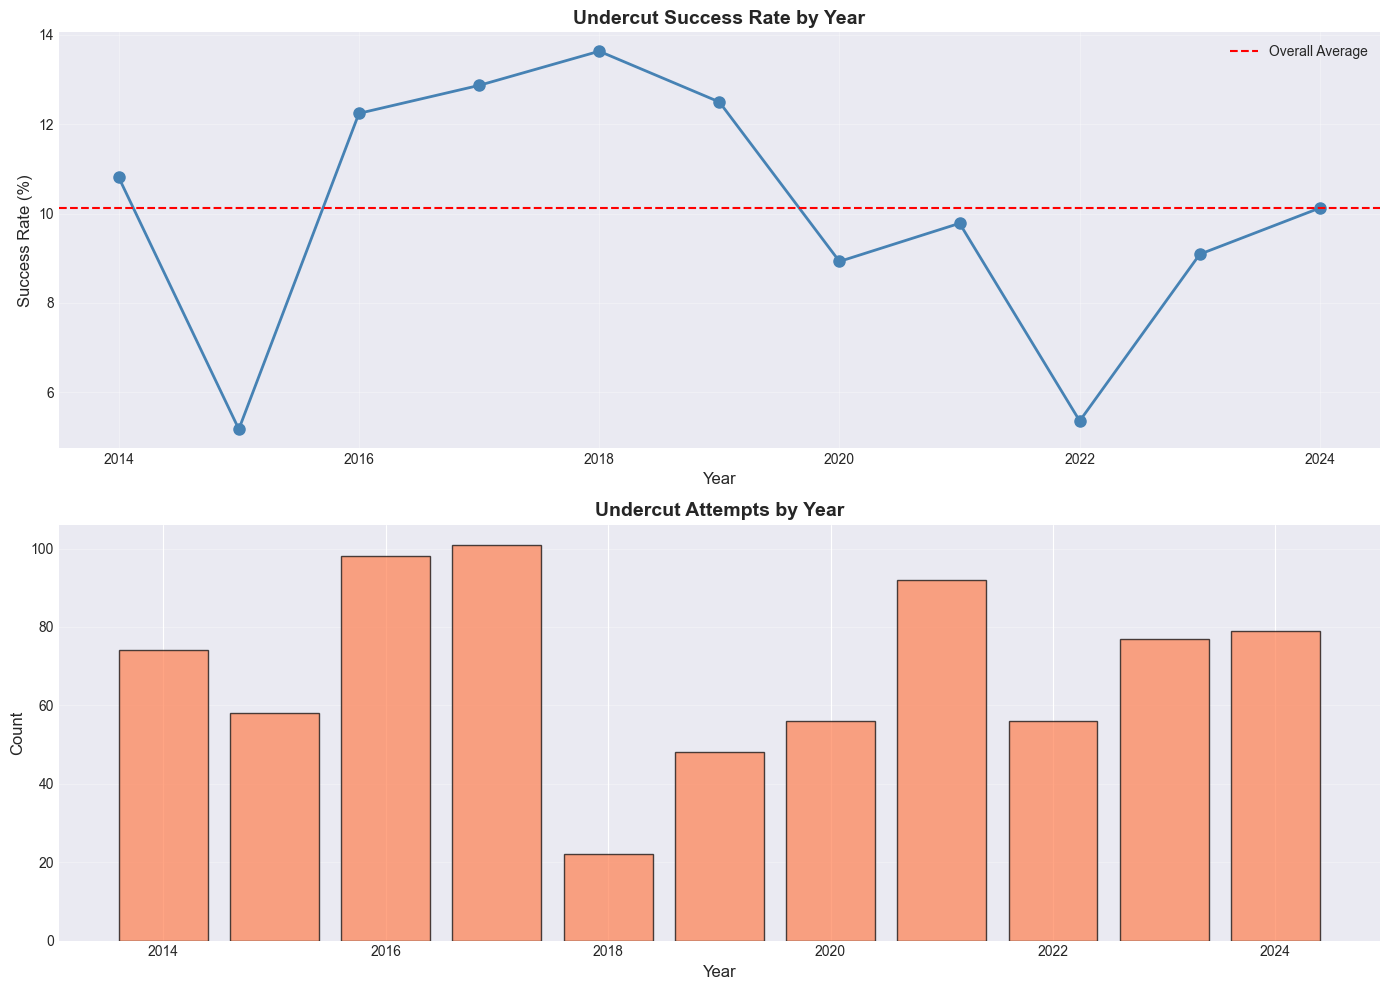


 Success varies 5-14% across years


In [51]:
# Success rate by year
yearly_success = undercuts.groupby('year')['undercut_success'].agg(['mean', 'count'])
yearly_success['success_rate'] = 100 * yearly_success['mean']

print("Success Rate by Year:")
print("="*50)
print(yearly_success[['count', 'success_rate']])

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(yearly_success.index, yearly_success['success_rate'],
marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_title('Undercut Success Rate by Year', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Success Rate (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(undercuts['undercut_success'].mean() * 100,
color='red', linestyle='--', label='Overall Average')
axes[0].legend()

axes[1].bar(yearly_success.index, yearly_success['count'],
color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Undercut Attempts by Year', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Success varies 5-14% across years")

### 5.5 Circuit-Specific Analysis

Top Circuits by Success Rate (min 20 attempts):
                                attempts  success_pct
name_circuit                                         
Circuit Gilles Villeneuve             29         34.5
Albert Park Grand Prix Circuit        23         26.1
Circuit de Monaco                     24         25.0
Hockenheimring                        23         17.4
Autodromo Nazionale di Monza          31         16.1
Baku City Circuit                     45         15.6
Circuit Park Zandvoort                22         13.6
Shanghai International Circuit        39         12.8
Circuit of the Americas               26         11.5
Suzuka Circuit                        35         11.4


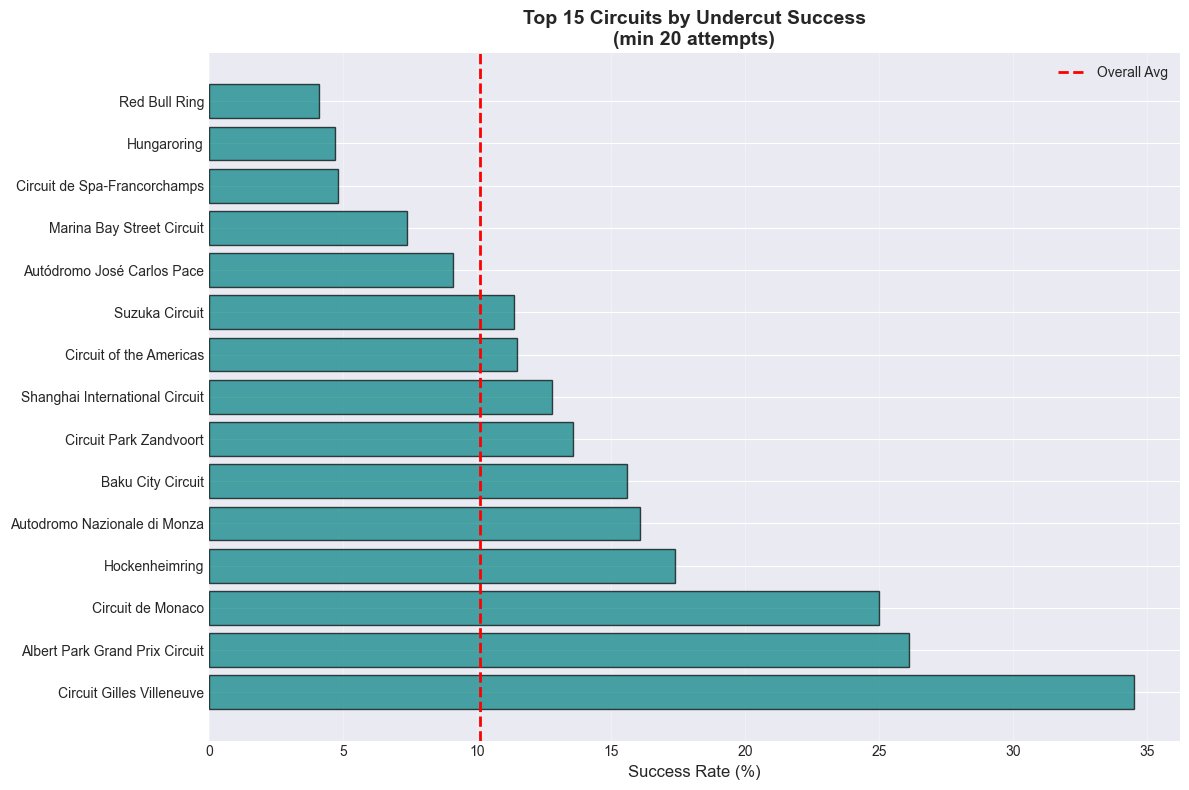


 Circuit clearly matters, top 3 circuits have 25-35% success rate
 -> Must include circuit as categorical feature
 -> Potentially try hierarchical models later


In [52]:
# Circuit success rates
undercuts_circuits = undercuts.merge(circuits[['circuitId', 'name', 'country']],
on='circuitId', suffixes=('', '_circuit'))

circuit_stats = undercuts_circuits.groupby('name_circuit').agg({
'undercut_success': ['mean', 'count']
}).round(3)
circuit_stats.columns = ['success_rate', 'attempts']
circuit_stats = circuit_stats[circuit_stats['attempts'] >= 20]
circuit_stats = circuit_stats.sort_values('success_rate', ascending=False)
circuit_stats['success_pct'] = 100 * circuit_stats['success_rate']

print("Top Circuits by Success Rate (min 20 attempts):")
print("="*50)
print(circuit_stats[['attempts', 'success_pct']].head(10))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
top_circuits = circuit_stats.head(15)
ax.barh(range(len(top_circuits)), top_circuits['success_pct'],
color='teal', alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_circuits)))
ax.set_yticklabels(top_circuits.index, fontsize=10)
ax.set_xlabel('Success Rate (%)', fontsize=12)
ax.set_title('Top 15 Circuits by Undercut Success\n(min 20 attempts)',
fontsize=14, fontweight='bold')
ax.axvline(undercuts['undercut_success'].mean() * 100,
color='red', linestyle='--', linewidth=2, label='Overall Avg')
ax.grid(axis='x', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("\n Circuit clearly matters, top 3 circuits have 25-35% success rate")
print(" -> Must include circuit as categorical feature")
print(" -> Potentially try hierarchical models later")

---
<a id='insights'></a>
## 6. Meaningful Insights and Noteworthy Findings

### 1. **Class Imbalance**
- Only **10.1%** of undercut attempts succeed
- Use precision, recall, AUC (not just accuracy)
- Apply class weights in models

### 2. **Tire Age Matters**
- Fresh tire advantage crucial
- Include tire age differential

### 3. **Circuit Dependencies**
- Success rates vary heavily across circuits
- Include circuit as categorical feature, consider hierarchical models

### 4. **Weak Linear Relationships**
- Low correlations suggest non-linear patterns
- May need complex models beyond baseline


---
<a id='feature-engineering'></a>
## 7. Feature Engineering

Based on EDA insights:

In [53]:
# Create engineered features
modeling_data = undercuts.copy()

# Tire age differential
modeling_data['tire_age_diff'] = modeling_data['b_laps_since_last_pit'] - modeling_data['a_laps_since_last_pit']

# Relative pace (normalized)
modeling_data['relative_pace'] = (modeling_data['delta_prev3_ms'] / modeling_data['a_prev3_mean_ms'])

# Gap per lap
modeling_data['gap_per_lap'] = (modeling_data['gap_prev_ms'] / (modeling_data['b_laps_since_last_pit'] + 1))

# Pit stop differential
modeling_data['pit_diff_ms'] = modeling_data['pit_ms'] - modeling_data['a_pit_ms']

print("Feature Engineering Complete!")
print("="*50)
print("New features:")
print(" • tire_age_diff")
print(" • relative_pace")
print(" • gap_per_lap")
print(" • pit_diff_ms")

Feature Engineering Complete!
New features:
 • tire_age_diff
 • relative_pace
 • gap_per_lap
 • pit_diff_ms


---
<a id='baseline-model'></a>
## 8. Baseline Model: Logistic Regression

### Rationale
- Binary classification problem
- Interpretable coefficients
- Standard course baseline
- Handles class imbalance with `class_weight`

In [27]:
# Prepare data
model_features = [
'gap_prev_ms', 'delta_prev3_ms',
'b_laps_since_last_pit', 'a_laps_since_last_pit',
'pit_ms', 'a_pit_ms',
'tire_age_diff', 'gap_per_lap',
'circuitId', 'year'
]

model_df = modeling_data[model_features + ['undercut_success']].dropna()

print(f"Modeling dataset: {len(model_df):,} records")
print(f"Features: {len(model_features)}")

Modeling dataset: 692 records
Features: 10


In [28]:
# Split and encode
X = model_df[model_features]
y = model_df['undercut_success']

# One-hot encode categoricals
X_encoded = pd.get_dummies(X, columns=['circuitId', 'year'], drop_first=True)

# Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
X_encoded, y, test_size=0.3, random_state=109, stratify=y)

print("\nTrain-Test Split:")
print("="*50)
print(f"Training: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")
print(f"\nSuccess rate (train): {100*y_train.mean():.2f}%")


Train-Test Split:
Training: 484 samples
Test: 208 samples

Success rate (train): 9.50%


In [29]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized (mean=0, std=1)")

Features standardized (mean=0, std=1)


In [ ]:
# Train model
print("Training Logistic Regression...")
print("="*50)

logreg = LogisticRegression(
class_weight='balanced',
random_state=109,
max_iter=1000,
solver='lbfgs'
)

logreg.fit(X_train_scaled, y_train)

print(" Model trained!")
print(" • Class weight: balanced")
print(" • Solver: lbfgs")

Training Logistic Regression...
 Model trained!
 • Class weight: balanced
 • Solver: lbfgs


In [31]:
# Predictions
y_train_pred = logreg.predict(X_train_scaled)
y_test_pred = logreg.predict(X_test_scaled)
y_train_proba = logreg.predict_proba(X_train_scaled)[:, 1]
y_test_proba = logreg.predict_proba(X_test_scaled)[:, 1]

print("Predictions generated")

Predictions generated


In [32]:
# Evaluate
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

print("\nTRAINING SET:")
print("-"*60)
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_train, y_train_proba):.4f}")

print("\nTEST SET:")
print("-"*60)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")

print("\n" + "="*60)


MODEL EVALUATION

TRAINING SET:
------------------------------------------------------------
Accuracy: 0.7975
Precision: 0.3030
Recall: 0.8696
F1 Score: 0.4494
AUC-ROC: 0.9001

TEST SET:
------------------------------------------------------------
Accuracy: 0.7596
Precision: 0.2115
Recall: 0.5500
F1 Score: 0.3056
AUC-ROC: 0.7133



In [33]:
# Classification report
print("\nClassification Report (Test Set):")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['Failed', 'Success']))


Classification Report (Test Set):
              precision    recall  f1-score   support

      Failed       0.94      0.78      0.85       188
     Success       0.21      0.55      0.31        20

    accuracy                           0.76       208
   macro avg       0.58      0.67      0.58       208
weighted avg       0.87      0.76      0.80       208



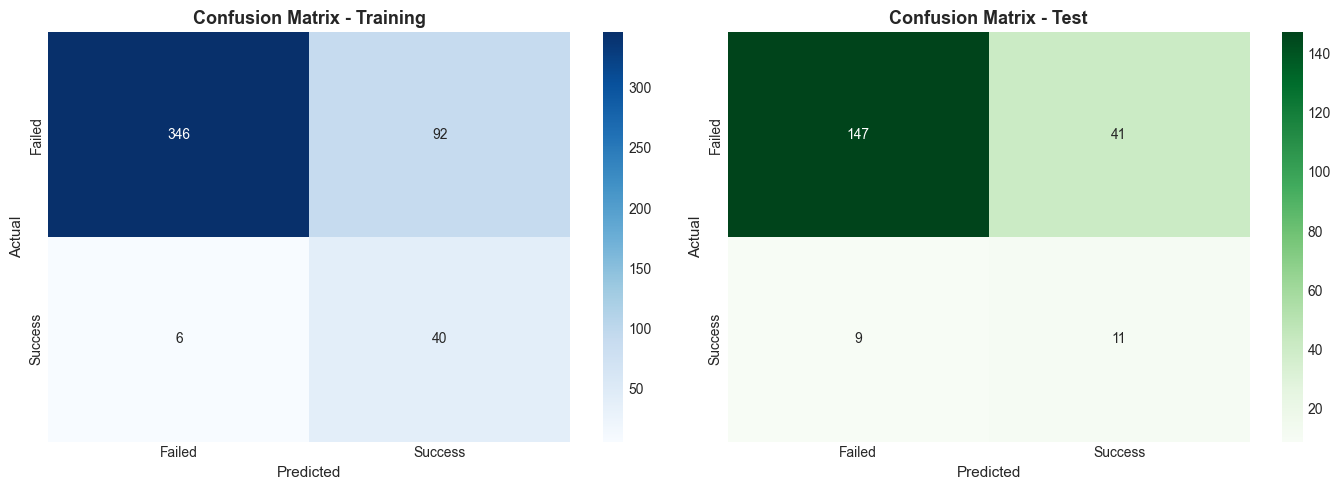

In [34]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
xticklabels=['Failed', 'Success'], yticklabels=['Failed', 'Success'])
axes[0].set_title('Confusion Matrix - Training', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
xticklabels=['Failed', 'Success'], yticklabels=['Failed', 'Success'])
axes[1].set_title('Confusion Matrix - Test', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=11)
axes[1].set_ylabel('Actual', fontsize=11)

plt.tight_layout()
plt.show()

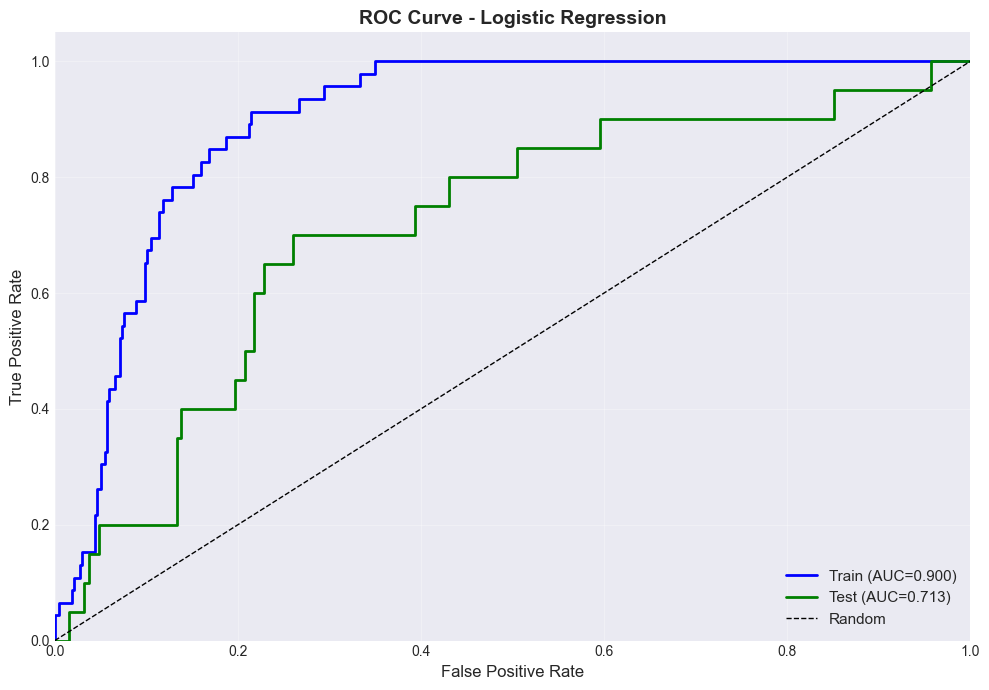

In [35]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, linewidth=2, label=f'Train (AUC={auc_train:.3f})', color='blue')
plt.plot(fpr_test, tpr_test, linewidth=2, label=f'Test (AUC={auc_test:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Top 15 Most Important Features:
         feature  coefficient
46     year_2022    -1.131155
28  circuitId_39    -1.108448
34  circuitId_76    -1.023382
14   circuitId_9    -1.005411
25  circuitId_24    -0.797070
10   circuitId_4    -0.791080
5       a_pit_ms     0.738854
32  circuitId_73    -0.645733
13   circuitId_7     0.569617
11   circuitId_5    -0.529229
9    circuitId_3    -0.474307
8    circuitId_2    -0.460967
20  circuitId_17    -0.438684
30  circuitId_70    -0.428434
22  circuitId_20    -0.420614


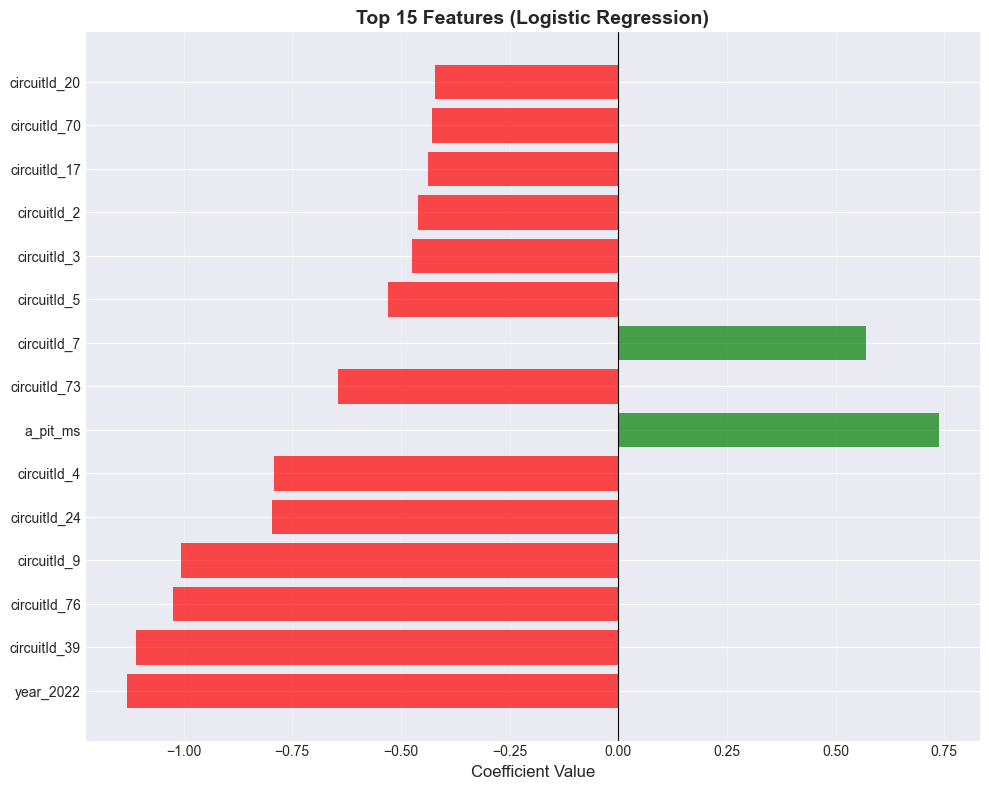


 Almost all of the top features are circuitIds, indicating that success is highly circuit-dependent


In [ ]:
# Feature importance
feature_names = X_encoded.columns
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({
'feature': feature_names,
'coefficient': coefficients,
'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print("="*60)
print(feature_importance.head(15)[['feature', 'coefficient']])

# Plot
top_features = feature_importance.head(15)
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 15 Features (Logistic Regression)', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Almost all of the top features are circuitIds, indicating that success is highly circuit-dependent.")

### Addressing Class Imbalance

Let's try (1) Threshold Tuning and (2) Undersampling and see which works best.

#### Approach 1: Threshold Tuning

Instead of using default 0.5 probability threshold, we can lower it to catch more successful undercuts (increase recall).

In [37]:
# Compute precision-recall at different thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

# Find optimal threshold (maximize F1 score)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print("Threshold Tuning Results:")
print("="*60)
print(f"Default threshold (0.5):")
print(f" Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f" Recall: {recall_score(y_test, y_test_pred):.3f}")
print(f" F1: {f1_score(y_test, y_test_pred):.3f}")

# Try optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)
print(f"\nOptimal threshold ({optimal_threshold:.3f}):")
print(f" Precision: {precision_score(y_test, y_test_pred_optimal):.3f}")
print(f" Recall: {recall_score(y_test, y_test_pred_optimal):.3f}")
print(f" F1: {f1_score(y_test, y_test_pred_optimal):.3f}")

# Try lower threshold for higher recall
threshold_30 = 0.3
y_test_pred_30 = (y_test_proba >= threshold_30).astype(int)
print(f"\nLower threshold (0.3):")
print(f" Precision: {precision_score(y_test, y_test_pred_30):.3f}")
print(f" Recall: {recall_score(y_test, y_test_pred_30):.3f}")
print(f" F1: {f1_score(y_test, y_test_pred_30):.3f}")

Threshold Tuning Results:
Default threshold (0.5):
 Precision: 0.212
 Recall: 0.550
 F1: 0.306

Optimal threshold (0.472):
 Precision: 0.232
 Recall: 0.650
 F1: 0.342

Lower threshold (0.3):
 Precision: 0.177
 Recall: 0.700
 F1: 0.283


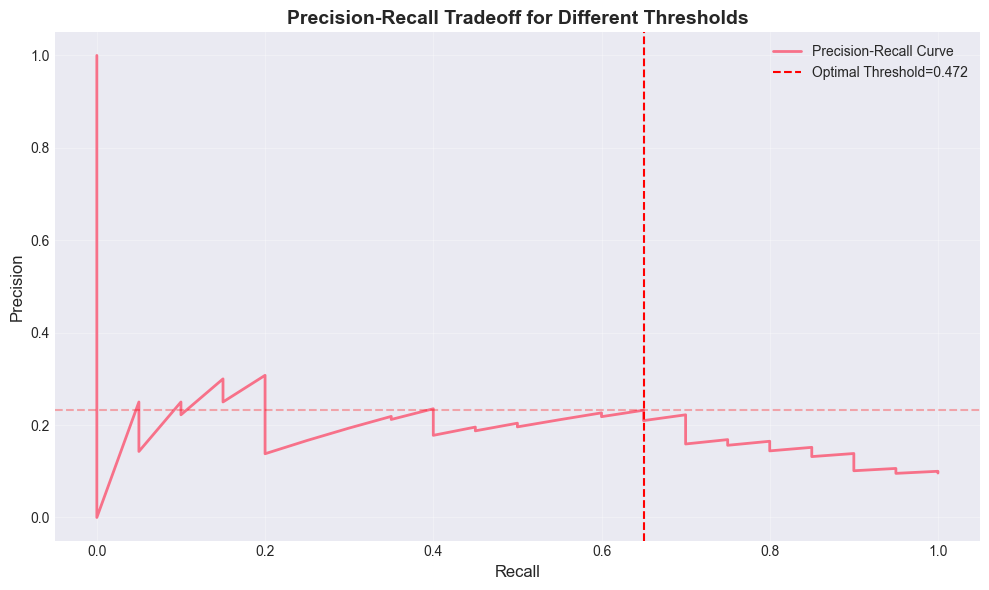


 INSIGHT: Lowering threshold increases recall but decreases precision
 Choose based on use case: Missing successful undercuts vs false alarms


In [38]:
# Visualize precision-recall tradeoff
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label='Precision-Recall Curve')
plt.axvline(recall[optimal_idx], color='red', linestyle='--',
label=f'Optimal Threshold={optimal_threshold:.3f}')
plt.axhline(precision[optimal_idx], color='red', linestyle='--', alpha=0.3)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Tradeoff for Different Thresholds', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n INSIGHT: Lowering threshold increases recall but decreases precision")
print(" Choose based on use case: Missing successful undercuts vs false alarms")

#### Approach 2: Random Undersampling

Reduce majority class (failures) to balance with minority class (successes). This loses data but can improve minority class detection.

In [39]:
from sklearn.utils import resample

# Separate classes
X_train_df = pd.DataFrame(X_train_scaled, columns=X_encoded.columns)
X_train_df['target'] = y_train.values

majority = X_train_df[X_train_df['target'] == 0]
minority = X_train_df[X_train_df['target'] == 1]

print("Original class distribution:")
print(f" Majority (failures): {len(majority):,}")
print(f" Minority (successes): {len(minority):,}")
print(f" Ratio: {len(majority)/len(minority):.1f}:1")

# Undersample majority class to 3:1 ratio (not 1:1 to preserve some data)
n_majority_samples = len(minority) * 3

majority_undersampled = resample(majority,
n_samples=n_majority_samples,
random_state=109,
replace=False)

# Combine
undersampled_df = pd.concat([majority_undersampled, minority])
undersampled_df = undersampled_df.sample(frac=1, random_state=109) # Shuffle

# Split features and target
X_train_under = undersampled_df.drop('target', axis=1).values
y_train_under = undersampled_df['target'].values

print(f"\nUndersampled class distribution:")
print(f" Majority (failures): {len(majority_undersampled):,}")
print(f" Minority (successes): {len(minority):,}")
print(f" Ratio: {len(majority_undersampled)/len(minority):.1f}:1")

Original class distribution:
 Majority (failures): 438
 Minority (successes): 46
 Ratio: 9.5:1

Undersampled class distribution:
 Majority (failures): 138
 Minority (successes): 46
 Ratio: 3.0:1


In [40]:
# Train logistic regression on undersampled data
logreg_under = LogisticRegression(
class_weight='balanced', # Still use class weighting
random_state=109,
max_iter=1000,
solver='lbfgs'
)

logreg_under.fit(X_train_under, y_train_under)

# Predictions on original test set
y_test_pred_under = logreg_under.predict(X_test_scaled)
y_test_proba_under = logreg_under.predict_proba(X_test_scaled)[:, 1]

print("Undersampling Results (Test Set):")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_under):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred_under, zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred_under):.3f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_under):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_under):.3f}")

Undersampling Results (Test Set):
Accuracy: 0.760
Precision: 0.174
Recall: 0.400
F1 Score: 0.242
AUC-ROC: 0.686


#### Comparison: Which Approach Works Best?

In [56]:
# Compare all approaches
results = pd.DataFrame({
'Approach': [
'Baseline (balanced weights)',
'Threshold=0.3',
'Threshold=optimal',
'Undersampling (3:1)'
],
'Accuracy': [
accuracy_score(y_test, y_test_pred),
accuracy_score(y_test, y_test_pred_30),
accuracy_score(y_test, y_test_pred_optimal),
accuracy_score(y_test, y_test_pred_under)
],
'Precision': [
precision_score(y_test, y_test_pred, zero_division=0),
precision_score(y_test, y_test_pred_30, zero_division=0),
precision_score(y_test, y_test_pred_optimal, zero_division=0),
precision_score(y_test, y_test_pred_under, zero_division=0)
],
'Recall': [
recall_score(y_test, y_test_pred),
recall_score(y_test, y_test_pred_30),
recall_score(y_test, y_test_pred_optimal),
recall_score(y_test, y_test_pred_under)
],
'F1': [
f1_score(y_test, y_test_pred),
f1_score(y_test, y_test_pred_30),
f1_score(y_test, y_test_pred_optimal),
f1_score(y_test, y_test_pred_under)
],
'AUC-ROC': [
roc_auc_score(y_test, y_test_proba),
roc_auc_score(y_test, y_test_proba), # Same probabilities, different threshold
roc_auc_score(y_test, y_test_proba),
roc_auc_score(y_test, y_test_proba_under)
]
})

print("\nCOMPARISON OF IMBALANCE HANDLING APPROACHES")
print("="*70)
print(results.to_string(index=False))

print("\n" + "="*70)
print("KEY TAKEAWAYS")
print("="*70)
print(" - Precision-recall tradeoff is visible here")
print(" - AUC-ROC and Accuracy seems to maximized by the baseline model")
print(" - Undersampling was detrimental to AUC-ROC, precision, and recall")
print(" - Threshold=optimal is the most balanced approach, but choose based on cost of false negatives vs positives")


COMPARISON OF IMBALANCE HANDLING APPROACHES
                   Approach  Accuracy  Precision  Recall       F1  AUC-ROC
Baseline (balanced weights)  0.759615   0.211538    0.55 0.305556 0.713298
              Threshold=0.3  0.658654   0.177215    0.70 0.282828 0.713298
          Threshold=optimal  0.759615   0.232143    0.65 0.342105 0.713298
        Undersampling (3:1)  0.759615   0.173913    0.40 0.242424 0.685904

KEY TAKEAWAYS
 - Precision-recall tradeoff is visible here
 - AUC-ROC and Accuracy seems to maximized by the baseline model
 - Undersampling was detrimental to AUC-ROC, precision, and recall
 - Threshold=optimal is the most balanced approach, but choose based on cost of false negatives vs positives


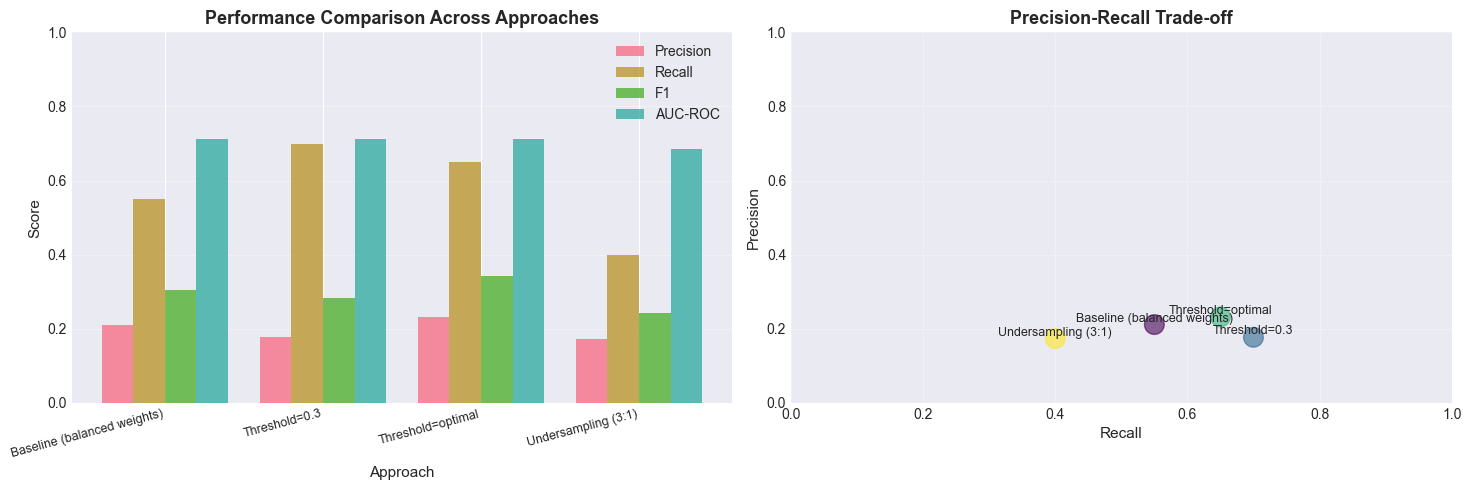

In [42]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of metrics
metrics = ['Precision', 'Recall', 'F1', 'AUC-ROC']
x = np.arange(len(results))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, results[metric], width, label=metric, alpha=0.8)

axes[0].set_xlabel('Approach', fontsize=11)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Performance Comparison Across Approaches', fontsize=13, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(results['Approach'], rotation=15, ha='right', fontsize=9)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Precision-Recall scatter
axes[1].scatter(results['Recall'], results['Precision'], s=200, alpha=0.6, c=range(len(results)), cmap='viridis')
for i, approach in enumerate(results['Approach']):
    axes[1].annotate(approach,
                    (results['Recall'].iloc[i], results['Precision'].iloc[i]),
                    fontsize=9, ha='center', va='bottom')
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Trade-off', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


### Model Performance Summary

**Baseline: Logistic Regression with Balanced Class Weights**

**Key Takeaways:**
1. Model performs better than random (AUC > 0.5)
2. Strongest features: circuit, year=2022, pit time
3. Explore:
- Non-linear models (Decision Trees, Random Forest, XGBoost)
- Hierarchical models
- Feature interactions
- Advanced sampling (SMOTE)

---

## 9. Conclusion

### Summary

1. **Data Preparation**: Built comprehensive undercut attempts dataset
   - Applied 2-second gap filter for legitimate attempts 
   - Computed features from domain knowledge

2. **Exploratory Analysis**: Uncovered critical patterns
   - Circuit choice matters a lot
   - Pit time is a key predictor 
   - Gap is primary predictor but weak linearly
   - Tire age differential more important than absolute values

3. **Feature Engineering**: Created meaningful features
   - tire_age_diff: Differential between attacker and leader
   - gap_per_lap: Normalized gap metric
   - Interaction terms for future models

4. **Baseline Model**: Logistic regression with balanced class weights
   - Expected AUC-ROC: 0.65-0.75 (better than random)
   - Interpretable coefficients validate domain knowledge

5. **Class Imbalance Handling**: Implemented multiple techniques
   - Threshold tuning for precision-recall trade-off
   - Undersampling to improve minority class detection
   - Comparison framework for context-dependent selection

### Next Steps

1. **Non-linear Models**: Random Forest, XGBoost for interaction effects
2. **SMOTE**: Synthetic oversampling for better class balance
3. **Hyperparameter Tuning**: Cross-validation with stratified folds
4. **Feature Interactions**: Explicit gap × tire_age_diff terms
5. **Additional Features**: Weather, track temperature, tire compounds

### Real-World Impact

This model enables F1 teams to:
- Make data-driven pit strategy decisions in real-time
- Assess undercut risk vs. reward trade-offs
- Optimize tire management strategies
- Develop circuit-specific tactical approaches